# Library

In [53]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

from transformers import BertTokenizer, TFBertModel, TFDistilBertModel

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

# Preprocessing

## Processing_text

In [5]:
# URL du dataset
url = 'https://fnd-jedha-project.s3.eu-west-3.amazonaws.com/0_WELFake_workbase.csv'

# Chargement du dataset
df = pd.read_csv(url)

# Affichage des premières lignes du dataset
print(df.head())


   label                                            message
0      0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...
1      0  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
2      1  Bobby Jindal, raised Hindu, uses story of Chri...
3      0  SATAN 2: Russia unvelis an image of its terrif...
4      0  About Time! Christian Group Sues Amazon and SP...


In [6]:
# Fonction de suppression des URLs
def remove_urls(text):
    # Supprimer les URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    return text

# Appliquer la fonction de suppression des URLs aux textes
df['message'] = df['message'].apply(remove_urls)

# Affichage des premières lignes du dataset nettoyé
print(df.head())


   label                                            message
0      0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...
1      0  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
2      1  Bobby Jindal, raised Hindu, uses story of Chri...
3      0  SATAN 2: Russia unvelis an image of its terrif...
4      0  About Time! Christian Group Sues Amazon and SP...


In [7]:
# Séparation des données
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['message'], df['label'], test_size=0.2, random_state=42)

print(f'Training set size: {len(train_texts)}')
print(f'Validation set size: {len(val_texts)}')


Training set size: 50496
Validation set size: 12625


In [8]:
# Chargement du tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Fonction de tokenisation
def encode_data(texts, tokenizer, max_len):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='tf',
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_masks)

# Tokenisation des textes
max_len = 128
train_input_ids, train_attention_masks = encode_data(train_texts, tokenizer, max_len)
val_input_ids, val_attention_masks = encode_data(val_texts, tokenizer, max_len)

# Affichage des dimensions des tenseurs
print(f'Train input_ids shape: {train_input_ids.shape}')
print(f'Train attention_masks shape: {train_attention_masks.shape}')
print(f'Val input_ids shape: {val_input_ids.shape}')
print(f'Val attention_masks shape: {val_attention_masks.shape}')


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2681: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
2025-02-03 15:13:10.709721: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Train input_ids shape: (50496, 1, 128)
Train attention_masks shape: (50496, 1, 128)
Val input_ids shape: (12625, 1, 128)
Val attention_masks shape: (12625, 1, 128)


In [9]:
# Chargement du tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Fonction de tokenisation
def encode_data(texts, tokenizer, max_len):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='tf',
            truncation=True  # Ajout de l'argument truncation
        )
        input_ids.append(encoded_dict['input_ids'][0])  # Suppression de la dimension supplémentaire
        attention_masks.append(encoded_dict['attention_mask'][0])  # Suppression de la dimension supplémentaire

    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_masks)

# Tokenisation des textes
max_len = 128
train_input_ids, train_attention_masks = encode_data(train_texts, tokenizer, max_len)
val_input_ids, val_attention_masks = encode_data(val_texts, tokenizer, max_len)

# Affichage des dimensions des tenseurs
print(f'Train input_ids shape: {train_input_ids.shape}')
print(f'Train attention_masks shape: {train_attention_masks.shape}')
print(f'Val input_ids shape: {val_input_ids.shape}')
print(f'Val attention_masks shape: {val_attention_masks.shape}')


Train input_ids shape: (50496, 128)
Train attention_masks shape: (50496, 128)
Val input_ids shape: (12625, 128)
Val attention_masks shape: (12625, 128)


# Model

In [10]:
class NewsClassifier(tf.keras.Model):
    def __init__(self, n_classes):
        super(NewsClassifier, self).__init__()
        self.bert = TFBertModel.from_pretrained('bert-base-uncased')
        self.dropout = Dropout(0.3)
        self.classifier = Dense(n_classes, activation='softmax')

    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output, training=training)
        return self.classifier(pooled_output)

# Création du modèle
model = NewsClassifier(n_classes=2)

# Affichage de la structure du modèle
model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "news_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Affichage de la structure complète du modèle BERT
model.bert.summary()


Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
class NewsClassifier(tf.keras.Model):
    def __init__(self, n_classes):
        super(NewsClassifier, self).__init__()
        self.bert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = Dropout(0.3)
        self.classifier = Dense(n_classes)  # Suppression de l'activation softmax

    def call(self, inputs, attention_mask=None, training=False):
        outputs = self.bert(inputs, attention_mask=attention_mask)
        pooled_output = outputs[0][:, 0, :]  # Utiliser la sortie du premier token [CLS]
        pooled_output = self.dropout(pooled_output, training=training)
        return self.classifier(pooled_output)

# Création du modèle
model = NewsClassifier(n_classes=2)

# Compilation du modèle avec un taux d'apprentissage plus élevé
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Création des datasets TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': train_input_ids, 'attention_mask': train_attention_masks}, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': val_input_ids, 'attention_mask': val_attention_masks}, val_labels))

# Batching et shuffling des datasets avec une taille de batch plus petite
train_dataset = train_dataset.shuffle(1000).batch(16)
val_dataset = val_dataset.batch(16)

# Entraînement du modèle avec plus d'époques
model.fit(train_dataset, epochs=10, validation_data=val_dataset)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/10
3156/3156 ━━━━━━━━━━━━━━━━━━━━ 2209s 699ms/step - accuracy: 0.7070 - loss: 0.5600 - val_accuracy: 0.8351 - val_loss: 0.3938
Epoch 2/10
3156/3156 ━━━━━━━━━━━━━━━━━━━━ 2204s 698ms/step - accuracy: 0.8252 - loss: 0.3970 - val_accuracy: 0.8568 - val_loss: 0.3476
Epoch 3/10
3156/3156 ━━━━━━━━━━━━━━━━━━━━ 2206s 699ms/step - accuracy: 0.8494 - loss: 0.3573 - val_accuracy: 0.8688 - val_loss: 0.3234
Epoch 4/10
3156/3156 ━━━━━━━━━━━━━━━━━━━━ 2199s 697ms/step - accuracy: 0.8590 - loss: 0.3357 - val_accuracy: 0.8743 - val_loss: 0.3079
Epoch 5/10
3156/3156 ━━━━━━━━━━━━━━━━━━━━ 2188s 693ms/step - accuracy: 0.8632 - loss: 0.3226 - val_accuracy: 0.8800 - val_loss: 0.2973
Epoch 6/10
3156/3156 ━━━━━━━━━━━━━━━━━━━━ 2186s 693ms/step - accuracy: 0.8710 - loss: 0.3109 - val_accuracy: 0.8837 - val_loss: 0.2889
Epoch 7/10
3156/3156 ━━━━━━━━━━━━━━━━━━━━ 2388s 757ms/step - accuracy: 0.8741 - loss: 0.3027 - val_accuracy: 0.8858 - val_loss: 0.2817
Epoch 8/10
3156/3156 ━━━━━━━━━━━━━━━━━━━━ 2575s 816ms/s

In [13]:
# Évaluation du modèle
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


790/790 ━━━━━━━━━━━━━━━━━━━━ 434s 549ms/step - accuracy: 0.8886 - loss: 0.2743
Validation Loss: 0.26867467164993286
Validation Accuracy: 0.892910897731781


In [18]:
def preprocess_function(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="tf")

# Créer un tf.data.Dataset à partir des données textuelles
texts = ["This is a positive sentence.", "This is a negative sentence."]
inputs = preprocess_function(texts)
dataset = tf.data.Dataset.from_tensor_slices((inputs['input_ids'], inputs['attention_mask']))

# Faire des prédictions
predictions = model.predict(dataset.batch(2))  # Batch size = 2
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
[[ 0.7785117 -1.0290569]
 [ 0.5046627 -0.8220246]]


In [21]:
X_train = []
y_train = []

for features, labels in dataset:
    X_train.append(features.numpy())
    y_train.append(labels.numpy())

# Convertir en tableaux NumPy
X_train = np.array(X_train)
y_train = np.array(y_train)

2025-02-03 22:18:36.209399: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [29]:
for batch in val_dataset.take(1):
    print(batch)

type(batch)

({'input_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[  101,  6221,  8398, ...,  2009,  3310,   102],
       [  101,  1056, 28394, ...,  1055,  2880,   102],
       [  101, 14548,  3695, ...,  2032,  1012,   102],
       ...,
       [  101, 14910,  2050, ...,  1996,  2069,   102],
       [  101,  4845,  2600, ...,  2600,  1006,   102],
       [  101,  8112,  1521, ...,  9221,  2018,   102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>}, <tf.Tensor: shape=(16,), dtype=int64, numpy=array([0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0])>)


2025-02-03 22:26:56.661553: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


tuple

In [42]:
# Accéder au dictionnaire (input_ids et attention_mask)
input_ids = batch[0]['input_ids'].numpy()  # Extraire input_ids
attention_mask = batch[0]['attention_mask'].numpy()  # Extraire attention_mask

# Accéder aux étiquettes (labels)
labels = batch[1].numpy()  # Extraire les étiquettes

In [44]:
# Fusionner les batches
X_val_input_ids = np.concatenate(X_val_input_ids, axis=0)
X_val_attention_mask = np.concatenate(X_val_attention_mask, axis=0)
y_val = np.concatenate(y_val, axis=0)

# Vérifier les formes
print("Forme de X_val_input_ids après concaténation :", X_val_input_ids.shape)
print("Forme de y_val après concaténation :", y_val.shape)

Forme de X_val_input_ids après concaténation : (12625, 128)
Forme de y_val après concaténation : (12625,)


In [48]:
# Préparer les entrées pour le modèle
inputs = {
    'input_ids': X_val_input_ids,
    'attention_mask': X_val_attention_mask
}

# Faire des prédictions
y_pred = model.predict(inputs)

# Convertir les prédictions en classes (si c'est un problème de classification)
y_pred_classes = np.argmax(y_pred, axis=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 438s 1s/step


In [49]:
# Calculer le F1 score
f1 = f1_score(y_val, y_pred_classes, average='weighted')  # 'weighted' pour prendre en compte les classes déséquilibrées
print("F1 Score :", f1)

F1 Score : 0.8928785861584273


In [50]:
conf_matrix = confusion_matrix(y_val, y_pred_classes)
print("Matrice de confusion :")
print(conf_matrix)

# Normaliser la matrice de confusion en pourcentages
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Afficher la matrice de confusion en pourcentages
print("Matrice de confusion en pourcentages :")
print(conf_matrix_percent)

Matrice de confusion :
[[4976  694]
 [ 658 6297]]
Matrice de confusion en pourcentages :
[[87.76014109 12.23985891]
 [ 9.46081955 90.53918045]]


Matrice de confusion :
[[4976  694]
 [ 658 6297]]


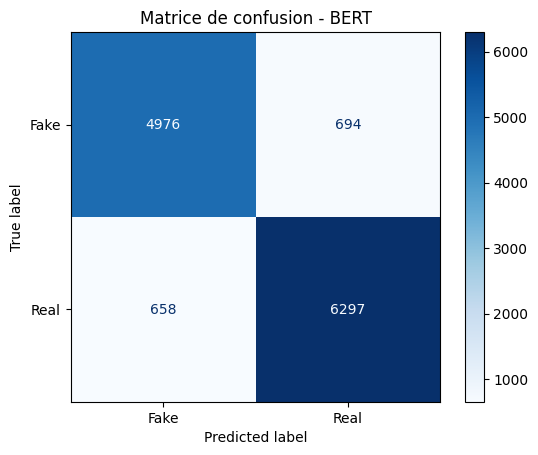

In [58]:
# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_val, y_pred_classes)
print("Matrice de confusion :")
print(conf_matrix)

# Supposons que vous avez des noms de classes
class_names = ['Fake', 'Real']

# Créer une visualisation de la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

# Afficher la matrice de confusion
disp.plot(cmap='Blues', values_format='d')  # 'd' pour afficher les valeurs en entiers
plt.title("Matrice de confusion - BERT")
plt.show()


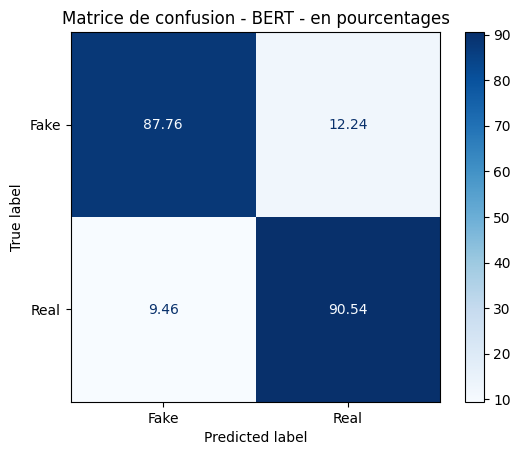

In [59]:
# Normaliser la matrice de confusion en pourcentages
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Créer une visualisation de la matrice de confusion en pourcentages
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percent, display_labels=class_names)

# Afficher la matrice de confusion en pourcentages
disp.plot(cmap='Blues', values_format='.2f')  # '.2f' pour afficher les valeurs avec 2 décimales
plt.title("Matrice de confusion - BERT - en pourcentages")
plt.show()

# Saving

In [ ]:
# Création du répertoire s'il n'existe pas
os.makedirs('fake_news_detector', exist_ok=True)

# Sauvegarde du modèle en format .keras
model.save('fake_news_detector/model.keras')


In [ ]:
# Sauvegarde des poids du modèle
model.save_weights('fake_news_detector/model_weights.weights.h5')


## Téléchargement des Fichiers Sauvegardés sur pc

In [ ]:
# Téléchargement du fichier du modèle
files.download('fake_news_detector/model.keras')

# Téléchargement du fichier des poids du modèle
files.download('fake_news_detector/model_weights.weights.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Lister les fichiers dans le répertoire fake_news_detector
files = os.listdir('fake_news_detector')
print(files)


['model.pkl', 'model.keras', 'model_weights.weights.h5']


In [ ]:
# Lister les fichiers dans le répertoire courant
files = os.listdir('.')
print(files)


['.config', 'fake_news_detector', 'sample_data']
